In [1]:
output_dir = "/JTE-607/Analysis/combined_backbones_mincov1_H1shortN4indel/Figure_4"

len(L3_APARENT_iso_pred_cut_nuc_scores) =  1908
len(L3_cleaved_input_enrichment) =  1908
correlation =  (0.6023068524473999, 9.410103137889289e-189)
correlation =  SpearmanrResult(correlation=0.5371039499339245, pvalue=4.625318805050055e-143)
len(SVLst_APARENT_iso_pred_cut_nuc_scores) =  1842
len(SVLst_cleaved_input_enrichment) =  1842
correlation =  (0.7213076922580729, 8.240366158028255e-296)
correlation =  SpearmanrResult(correlation=0.7149859787691527, pvalue=2.579911755208767e-288)


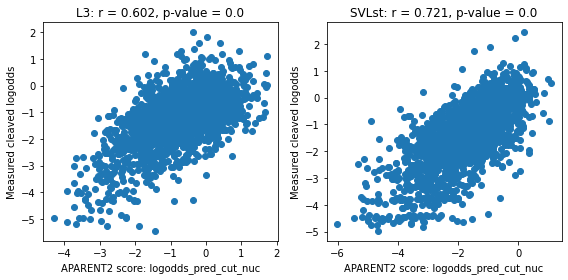

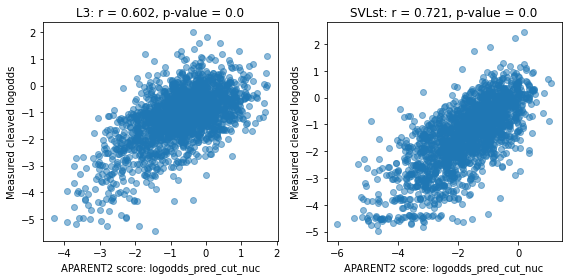

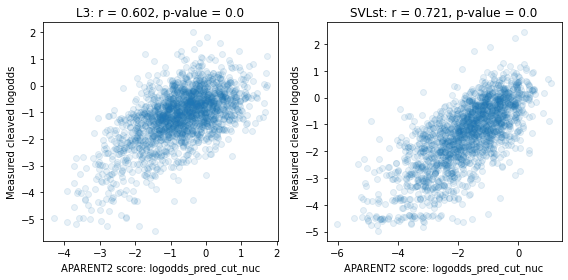

In [2]:
from scipy import stats
import matplotlib.pyplot as plt
from scipy.special import logit

# checking correlation between APARENT scores and input / DMSO reads
# calculating normalized input percentages, filtering for min coverage of 50 reads

def load_input_percentages(barcode_clusters_culled_file, min_cov=100):
    barcode_percents = {}
    with open(barcode_clusters_culled_file, "r") as f:
        f.readline()  # throw out header
        total_reads = 0
        for line in f:
            var = line.split("\t")
            barcode = var[0]
            coverage = float(var[2])
            total_reads += coverage
            if coverage >= min_cov:
                barcode_percents[barcode] = coverage

    for barcode, reads in barcode_percents.items():
        barcode_percents[barcode] = barcode_percents[barcode]/total_reads
    
    return barcode_percents


def load_DMSO_percentages_cutsite(PAS_read_counts_file, cut_site=46, min_cov=100):
    barcode_percents = {}
    with open(PAS_read_counts_file, "r") as f:
        total_reads = 0
        for line in f:
            var = line.split("\t")
            barcode = var[0]
            cut_pos = int(var[1])
            coverage = float(var[2])
            total_reads += coverage
            if coverage >= min_cov and cut_pos == cut_site:
                barcode_percents[barcode] = coverage

    for barcode, reads in barcode_percents.items():
        barcode_percents[barcode] = barcode_percents[barcode]/total_reads
    
    return barcode_percents


# L3 input
L3_barcode_clusters_culled_file = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/L3_input_barcode_clusters_consensus_seq_culled.txt"
L3_barcode_percents = load_input_percentages(L3_barcode_clusters_culled_file, min_cov=150)

# SVLst input
SVLst_barcode_clusters_culled_file = "/JTE-607/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/SVLst_input_barcode_clusters_consensus_seq_culled.txt"
SVLst_barcode_percents = load_input_percentages(SVLst_barcode_clusters_culled_file, min_cov=150)

# L3 DMSO
L3_DMSO_PAS_read_counts_file = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/L3_DMSO_polya_pos.txt"
L3_DMSO_barcode_percents = load_DMSO_percentages_cutsite(L3_DMSO_PAS_read_counts_file, cut_site=46, min_cov=1)

# SVLst DMSO
SVLst_DMSO_PAS_read_counts_file = "/JTE-607/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_SVLst_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/SVLst_DMSO_polya_pos.txt"
SVLst_DMSO_barcode_percents = load_DMSO_percentages_cutsite(SVLst_DMSO_PAS_read_counts_file, cut_site=46, min_cov=1)

# Calculate estimated cleavage rate = DMSO % / input %
# L3 estimated cleavage rate
L3_cleaved_enrichment = {}
for PAS, input_percentage in L3_barcode_percents.items():
    if PAS in L3_DMSO_barcode_percents:
        p = L3_DMSO_barcode_percents[PAS] / (L3_DMSO_barcode_percents[PAS] + L3_barcode_percents[PAS])
        L3_cleaved_enrichment[PAS] = logit(p)
    #else:
    #    L3_cleaved_enrichment[PAS] = 0

# SVLst estimated cleavage rate
SVLst_cleaved_enrichment = {}
for PAS, input_percentage in SVLst_barcode_percents.items():
    if PAS in SVLst_DMSO_barcode_percents:
        p = SVLst_DMSO_barcode_percents[PAS] / (SVLst_DMSO_barcode_percents[PAS] + SVLst_barcode_percents[PAS])
        SVLst_cleaved_enrichment[PAS] = logit(p)
    #else:
    #    SVLst_cleaved_enrichment[PAS] = 0
# cleanup
del SVLst_DMSO_barcode_percents, SVLst_barcode_percents, L3_DMSO_barcode_percents, L3_barcode_percents

# parsing through APARENT scores
APARENT_score_file = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose/collapsed/all_DMSO_sequences_shifted_pred.csv"
APARENT_iso_pred_cut_nuc_scores = []
L3_APARENT_iso_pred_cut_nuc_scores = []
L3_cleaved_input_enrichment = []
SVLst_APARENT_iso_pred_cut_nuc_scores = []
SVLst_cleaved_input_enrichment = []

with open(APARENT_score_file, "r") as f:
    f.readline()  # throw out header
    for line in f:
        var = line.split("\t")
        sequence = var[0]
        iso_pred_cut_nuc = float(var[14])  # iso_pred_cut_nuc
        PAS = sequence[76:101]  # b/c shifted to same location in APARENT
        if sequence[:3] == "NNN":
            # L3 variant
            if PAS in L3_cleaved_enrichment:
                APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                L3_APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                L3_cleaved_input_enrichment.append(L3_cleaved_enrichment[PAS])
        else:
            # SVLst variant
            if PAS in SVLst_cleaved_enrichment:
                APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                SVLst_APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                SVLst_cleaved_input_enrichment.append(SVLst_cleaved_enrichment[PAS])

print("len(L3_APARENT_iso_pred_cut_nuc_scores) = ", len(L3_APARENT_iso_pred_cut_nuc_scores))
print("len(L3_cleaved_input_enrichment) = ", len(L3_cleaved_input_enrichment))

L3_correlation = stats.pearsonr(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_input_enrichment)
print("correlation = ", L3_correlation)
correlation = stats.spearmanr(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_input_enrichment)
print("correlation = ", correlation)

print("len(SVLst_APARENT_iso_pred_cut_nuc_scores) = ", len(SVLst_APARENT_iso_pred_cut_nuc_scores))
print("len(SVLst_cleaved_input_enrichment) = ", len(SVLst_cleaved_input_enrichment))

SVLst_correlation = stats.pearsonr(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_input_enrichment)
print("correlation = ", SVLst_correlation)
correlation = stats.spearmanr(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_input_enrichment)
print("correlation = ", correlation)

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_input_enrichment, 'o')
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("Measured cleaved logodds")
ax[0].set_xlabel("APARENT2 score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_input_enrichment, 'o')
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("Measured cleaved logodds")
ax[1].set_xlabel("APARENT2 score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.show()

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_input_enrichment, 'o', alpha=0.5)
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("Measured cleaved logodds")
ax[0].set_xlabel("APARENT2 score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_input_enrichment, 'o', alpha=0.5)
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("Measured cleaved logodds")
ax[1].set_xlabel("APARENT2 score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.savefig(output_dir + "/DMSO_input_cut46_mincov150_APARENT2_logodds_pred_cut_nuc_alpha0p5.pdf")
plt.show()

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_cleaved_input_enrichment, 'o', alpha=0.1)
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("Measured cleaved logodds")
ax[0].set_xlabel("APARENT2 score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_cleaved_input_enrichment, 'o', alpha=0.1)
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("Measured cleaved logodds")
ax[1].set_xlabel("APARENT2 score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.savefig(output_dir + "/DMSO_input_cut46_mincov150_APARENT2_logodds_pred_cut_nuc_alpha0p1.pdf")
plt.show()

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model


def one_hot_encode(sequences, max_seq_len=164, mask_val=-1, padding='left'):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],
             'c':[0,1,0,0],
             'g':[0,0,1,0],
             't':[0,0,0,1],
             'n':[0,0,0,0],
            'm':[mask_val,mask_val,mask_val,mask_val]}
    
    # Creat empty matrix
    one_hot_seqs = np.ones([len(sequences), max_seq_len, 4])*mask_val
    
    # Iterate through sequences and one-hot encode
    for i, seq in enumerate(sequences):
        # Truncate
        seq = seq[:max_seq_len].lower()
        # Convert to array
        one_hot_seq = np.array([nuc_d[x] for x in seq])
        # Append to matrix
        if padding=='left':
            one_hot_seqs[i, :len(seq), :] = one_hot_seq
        elif padding=='right':
            one_hot_seqs[i, -len(seq):, :] = one_hot_seq
        else:
            ValueError(f'padding {padding} not recognized')
            
    return one_hot_seqs


def C3PO_12p5_prediction(C3PO, PAS, input_len=25):
    seq_one_hot = one_hot_encode(PAS, max_seq_len=input_len)
    predictions = C3PO.predict(seq_one_hot)
    C3PO_logodds = []
    for i in predictions:
        _, _, logp_12p5 = i
        C3PO_logodds.append(logp_12p5)
    return C3PO_logodds



In [4]:
"""
Load best performing model with all data
"""

all_doses_trial_num = 6
models_dir = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/models_25nt_logratio_mixedsort_4120_batchnorm-07_25_2022-6epoch_x10/"
C3P0_ratios_model = load_model("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (models_dir, all_doses_trial_num))


[2022-11-22 02:19:08.205 ip-172-31-11-19.us-west-1.compute.internal:6885 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-22 02:19:08.228 ip-172-31-11-19.us-west-1.compute.internal:6885 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


len(L3_APARENT_iso_pred_cut_nuc_scores) =  1908
len(L3_C3PO_scores) =  1908
correlation =  (0.4184846224578635, 9.011104193588303e-82)
correlation =  SpearmanrResult(correlation=0.46124434221049865, pvalue=3.929603088333918e-101)
len(SVLst_APARENT_iso_pred_cut_nuc_scores) =  1842
len(SVLst_C3PO_scores) =  1842
correlation =  (0.24180792694493602, 6.445528332943104e-26)
correlation =  SpearmanrResult(correlation=0.2507166433540858, pvalue=8.461670813666294e-28)


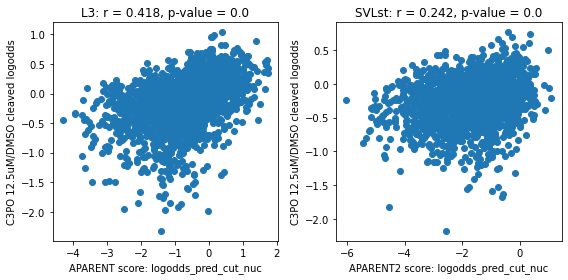

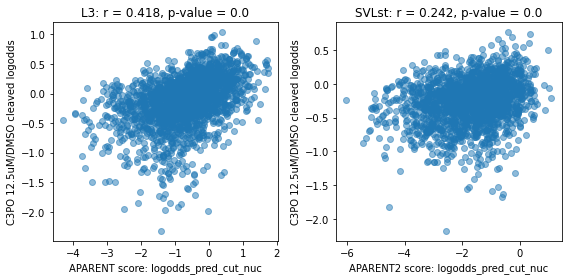

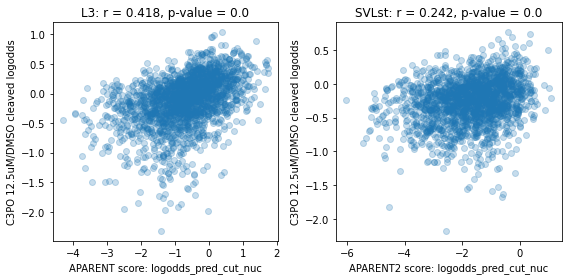

In [5]:
# parsing through APARENT scores and making C3PO predictions and then converting to logodds

APARENT_score_file = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose/collapsed/all_DMSO_sequences_shifted_pred.csv"
APARENT_iso_pred_cut_nuc_scores = []
L3_APARENT_iso_pred_cut_nuc_scores = []
L3_C3PO_scores = []
SVLst_APARENT_iso_pred_cut_nuc_scores = []
SVLst_C3PO_scores = []

with open(APARENT_score_file, "r") as f:
    f.readline()  # throw out header
    for line in f:
        var = line.split("\t")
        sequence = var[0]
        iso_pred_cut_nuc = float(var[14])  # iso_pred_cut_nuc
        PAS = sequence[76:101]  # b/c shifted to same location in APARENT
        if sequence[:3] == "NNN":
            # L3 variant
            if PAS in L3_cleaved_enrichment:
                C3PO_score = C3PO_12p5_prediction(C3P0_ratios_model, [PAS])  # make a single C3PO prediciton
                APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                L3_APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                L3_C3PO_scores.append(C3PO_score[0])  # only a single C3PO prediction
        else:
            # SVLst variant
            if PAS in SVLst_cleaved_enrichment:
                C3PO_score = C3PO_12p5_prediction(C3P0_ratios_model, [PAS])  # make a single C3PO prediciton
                APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                SVLst_APARENT_iso_pred_cut_nuc_scores.append(iso_pred_cut_nuc)
                SVLst_C3PO_scores.append(C3PO_score[0])  # only a single C3PO prediction

print("len(L3_APARENT_iso_pred_cut_nuc_scores) = ", len(L3_APARENT_iso_pred_cut_nuc_scores))
print("len(L3_C3PO_scores) = ", len(L3_C3PO_scores))

L3_correlation = stats.pearsonr(L3_APARENT_iso_pred_cut_nuc_scores, L3_C3PO_scores)
print("correlation = ", L3_correlation)
correlation = stats.spearmanr(L3_APARENT_iso_pred_cut_nuc_scores, L3_C3PO_scores)
print("correlation = ", correlation)

print("len(SVLst_APARENT_iso_pred_cut_nuc_scores) = ", len(SVLst_APARENT_iso_pred_cut_nuc_scores))
print("len(SVLst_C3PO_scores) = ", len(SVLst_C3PO_scores))

SVLst_correlation = stats.pearsonr(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_C3PO_scores)
print("correlation = ", SVLst_correlation)
correlation = stats.spearmanr(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_C3PO_scores)
print("correlation = ", correlation)

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_C3PO_scores, 'o')
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("C3PO 12.5uM/DMSO cleaved logodds")
ax[0].set_xlabel("APARENT score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_C3PO_scores, 'o')
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("C3PO 12.5uM/DMSO cleaved logodds")
ax[1].set_xlabel("APARENT2 score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.show()

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_C3PO_scores, 'o', alpha=0.5)
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("C3PO 12.5uM/DMSO cleaved logodds")
ax[0].set_xlabel("APARENT score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_C3PO_scores, 'o', alpha=0.5)
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("C3PO 12.5uM/DMSO cleaved logodds")
ax[1].set_xlabel("APARENT2 score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.savefig(output_dir + "/C3PO_12p5_DMSO_logodds_APARENT2_logodds_pred_cut_nuc_alpha0p5.pdf")
plt.show()

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(L3_APARENT_iso_pred_cut_nuc_scores, L3_C3PO_scores, 'o', alpha=0.25)
ax[0].set_title("L3: r = " + str(round(L3_correlation[0], 3))+ ", p-value = " + str(round(L3_correlation[1], 3)))
ax[0].set_ylabel("C3PO 12.5uM/DMSO cleaved logodds")
ax[0].set_xlabel("APARENT score: logodds_pred_cut_nuc")
ax[1].plot(SVLst_APARENT_iso_pred_cut_nuc_scores, SVLst_C3PO_scores, 'o', alpha=0.25)
ax[1].set_title("SVLst: r = " + str(round(SVLst_correlation[0], 3)) + ", p-value = " + str(round(SVLst_correlation[1], 3)))
ax[1].set_ylabel("C3PO 12.5uM/DMSO cleaved logodds")
ax[1].set_xlabel("APARENT2 score: logodds_pred_cut_nuc")
plt.tight_layout()
plt.savefig(output_dir + "/C3PO_12p5_DMSO_logodds_APARENT2_logodds_pred_cut_nuc_alpha0p25.pdf")
plt.show()